In [1]:
import pyfvda.eventProcessor as processor
import pyfvda.eventTimingGroup as timingGroup
import numpy as np
import pandas as pd
# %matplotlib widget # For interactive plots

## Read the event list and download data from CDAWeb

#### 1. The eventList.xlsx contains 6 necessary columns ['SC', 'pitch angle bin', 'start time', 'end time', 'hour', 'class']

- 'SC': The name of spacecraft. Now it only supports 'WIND', 'STA', and 'STB'. Will support the 'Solar Orbiter' soon.
    
- 'pitch angle bin': The pitch angle bin idx of the instrument. 

    - For 'WIND', it has 8 bins, representing pitch angle from ~15 to ~ 165 deg. 

    - For the STEREO, there is a correspondence between the Instument ID and the column index, which is: ['Spec_0_E' -- 35, 'Spec_0_NS' -- 31, 'Spec_2_E' -- 37, 'Spec_2_NS' -- 33]. However, for STA and STB, the same sector of instrument observes different directions. 

    - STA: ['Spec_0_E': anti-sunward, 'Spec_0_NS': ecliptic north, 'Spec_2_E': sunward, 'Spec_2_NS': ecliptic south]
    - STB: ['Spec_0_E': sunward, 'Spec_0_NS': ecliptic south, 'Spec_2_E': anti-sunward, 'Spec_2_NS': ecliptic north]

- 'start time', 'end time': The time period for acquiring data.

- 'hour': Roughly estimated onset time of the event.

- 'class': The corresponding flare class of the SEE (Solar Energetic Electron) event. Can be an empty string.

#### 2. Class EventProcessor contains high-level methods for acquiring / pre-processing data, FVDA analysis / plotting, and saving results

#### 3. Explanation of the following block
- (1) Once we read the eventList and specify the index of the event, we can create the event object using 'pro.createEventObject()'
- (2) If 'savefig=True', the figure will be save in the ‘Event’ file in the current folder by default.
- (3) pro.getSolarWindSpeed() acquires and calculates the solar wind speed ahead the SEE event. vsw_range: the time period for calculating the Vsw. vsw_range can be empty list (will use default period, 11 hours before the event 'hour').

/Users/xwu/opt/miniconda3/envs/pyFVDA/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:891: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x304414610> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)


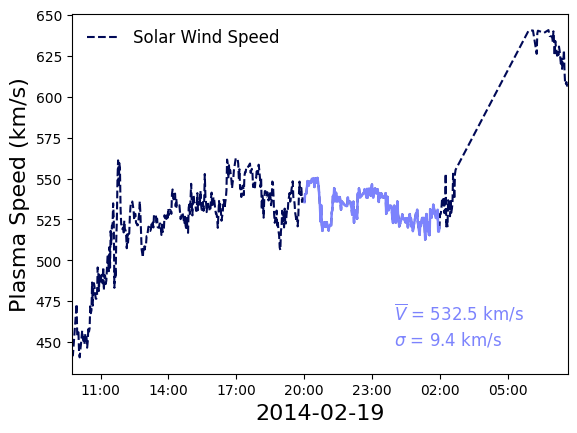

In [4]:
# Read event list
event_list = processor.load_event_list('./eventListForTest.xlsx')
pro = processor.EventProcessor(event_list, idx=3)
event = pro.createEventObject(plotfig=True, savefig=False)

vsw_range=[pd.Timestamp('2014-02-19 20:00:00',tz='UTC'), pd.Timestamp('2014-02-20 02:00:00',tz='UTC')]
pro.getSolarWindSpeed(vsw_range) # Stored in pro.event.vsw & pro.event.parker

## Data smoothing
- (1) pro.prepare_data(): allows the user to adjust the window size of Savitzky–Golay filter. 
    - **initial_WindowSize** (default: [7]*6): initial window size. The window size should be odd.
    - **polyorder** (default: [2]*6): polynominal order.
    - **timeForFvda** (default: []): time period for applying the SG filter & FVDA analysis. By default, the whole data is processed.

- (2) Note:
    - The input of the next processing method "pro.getTime_eta()" is determined by the result from this step.


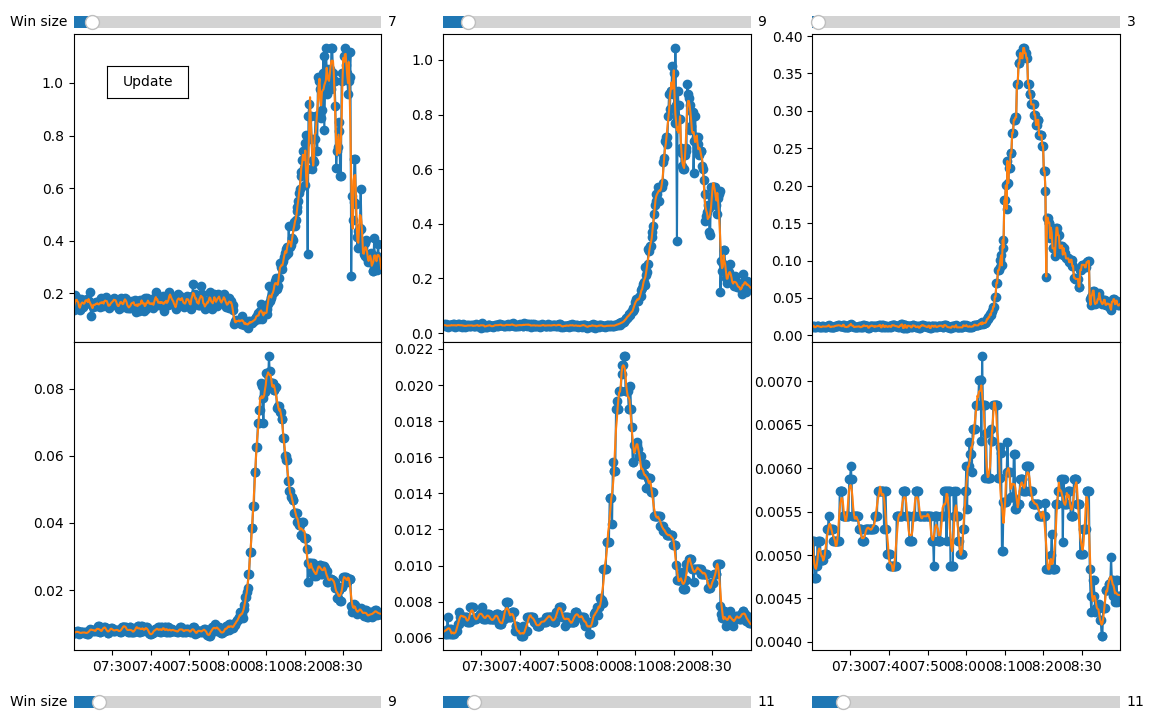

! Specify: "bins, background range, peak range" before call the "getTime_eta" method.


In [5]:
# smooth data. Interactive Interface.
pro.prepare_data(initial_WindowSize = [7,9,3,9,11,11])

## Obtain the t(eta) of in-situ energetic electrons
- (1) pro.getTime_eta(): Find the t(eta) on the intensity profile.
    - **bgRange**: A list with two string elements, indicating the time period of the background flux.
    - **peakRange**: A list with two string elements, roughly indicating the range that the peak appears.
    - **binsForFvda**: Indices of the energy channel used for the FVDA analysis, based on the result from last step (data smoothing).
    - **eta**: An array of eta points. Remember to transpose the array.
    - **specialBg**: A dictionary containing the energy channel (string) and the corresponding background time period (a list of string). Allow the user to choose the time range of background for different energy channels.

    The output is a set of figures, including t(eta) and onset time based on different polynomial fitting.


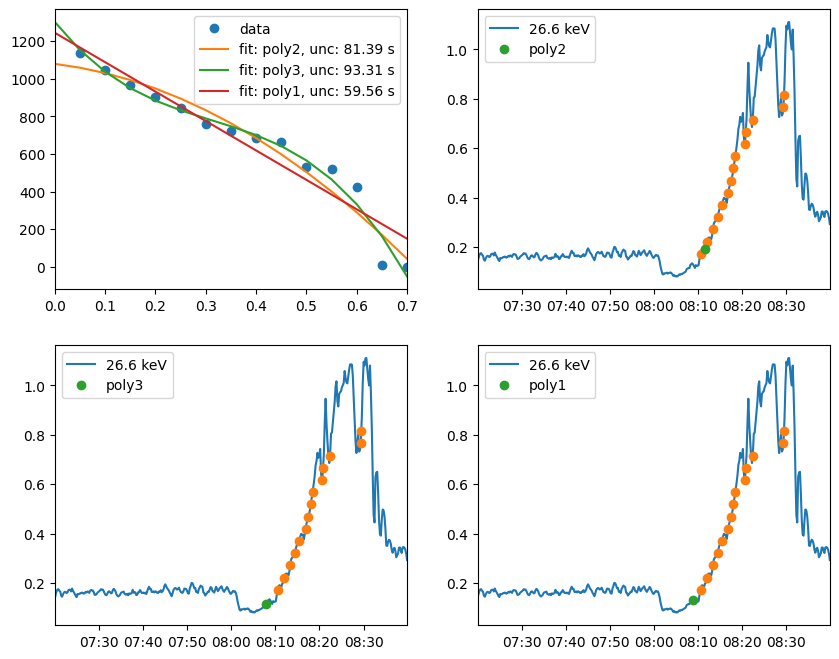

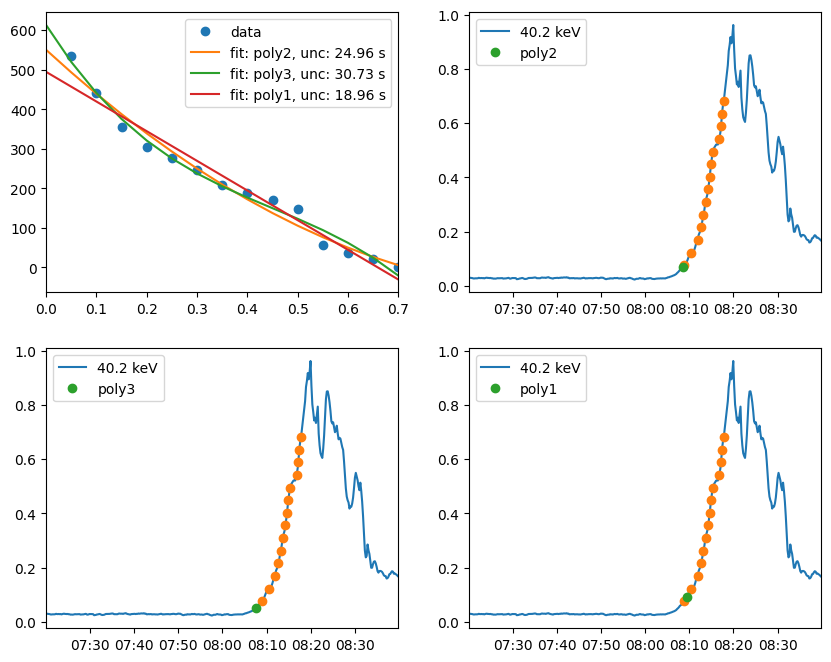

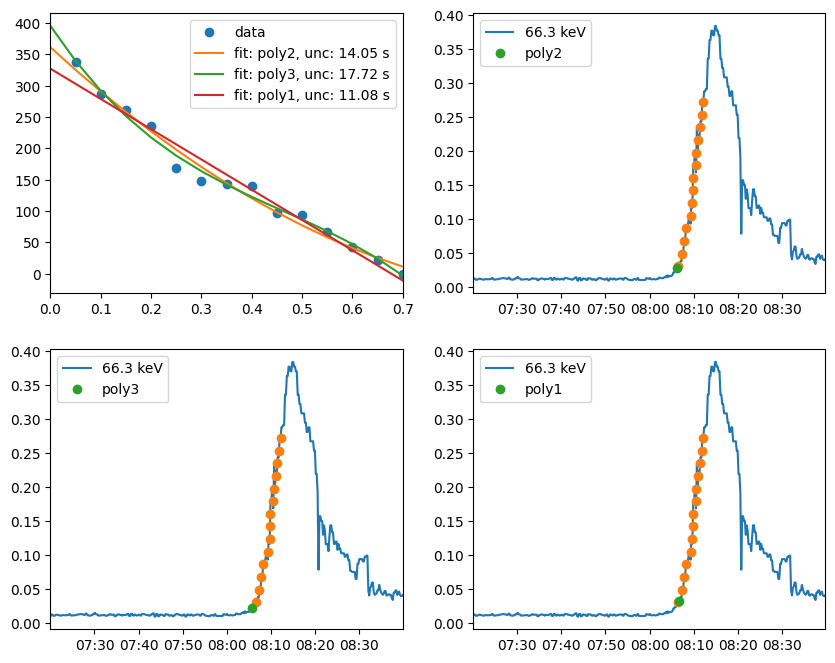

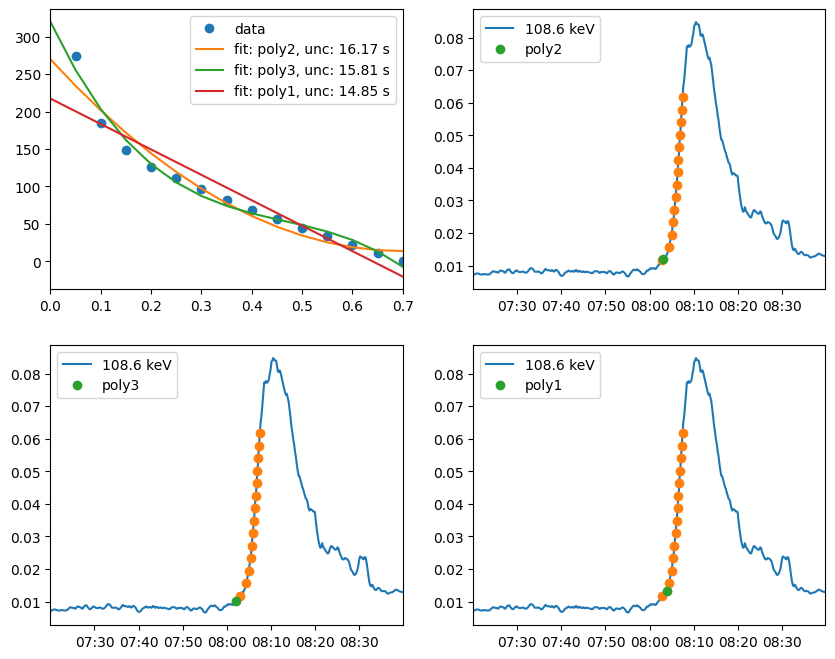

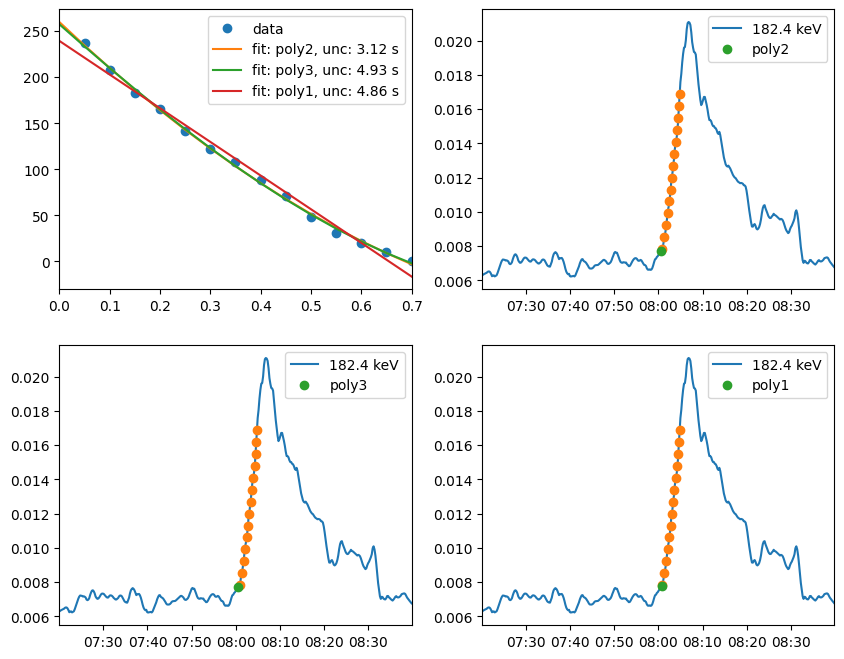

In [6]:
pro.getTime_eta(bgRange=['2014-02-20 07:40', '2014-02-20 07:50'], 
                peakRange=['2014-02-20 08:00', '2014-02-20 08:30'], 
                binsForFvda=[1, 2, 3, 4, 5], 
                eta= np.array([np.arange(0.7, 0, -0.05)]).T,
                specialBg = {'26.6 keV': ['2014-02-20 07:58', '2014-02-20 08:05'], '182.4 keV': ['2014-02-20 07:45', '2014-02-20 07:55']})


## Obtain the onset time
- (1) pro.getOnsetTime(): Get the electron onset time based on the selected fitting.
    - polyorder_toFitOnsetTime: A list of integers, indicating the polynomial order for extrapolating the onset time.

    Return the pro.event.onsetTime and pro.event.T0_uncertainty, which are the onset times and their uncertainties, respectively.

In [7]:

# The polynomial orders are determined based on results from the previous step.
polyorder_toFitOnsetTime = [2]*5
pro.getOnsetTime(polyorder_toFitOnsetTime)

## Perform FVDA-Approach 1 analysis
#### pro.fvda_approach1()
- eta_forDisplay (default: [0.7, 0.4, 0.15, 0]): Plotting the t(eta)--1/beta fitting results.

- etaRangeForFitting (default: np.arange(0.7,0.1,-0.05)): The eta used for PathLength--eta / ReleaseTime--eta (as eta -> 0) fitting.

The output is 2 figures. 

- One shows the results of t(eta)--1/beta fitting (providing the electron path length & release time).
    
- The other shows the summary results of the FVDA-Approach1.

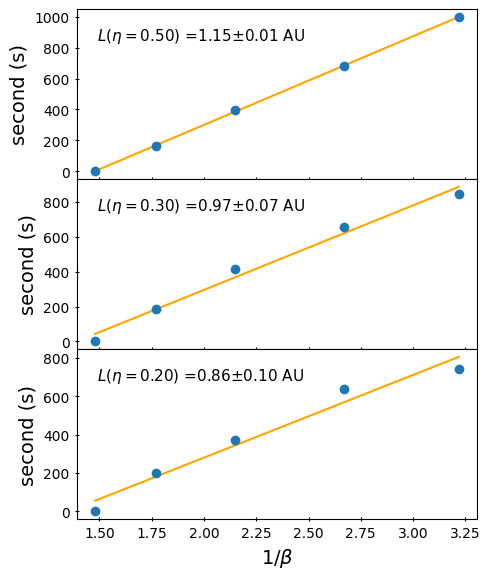

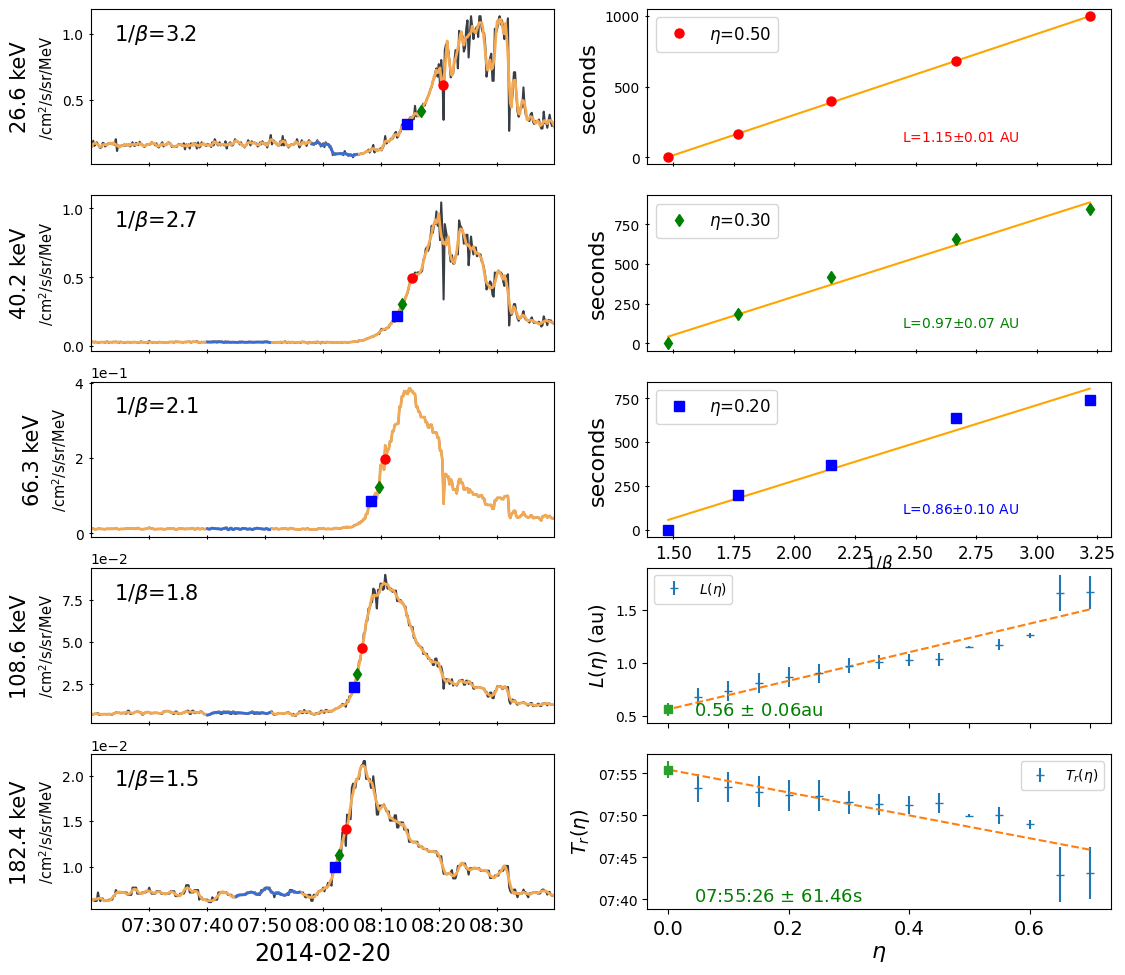

In [8]:
# FVDA approach 1
# will get event.pathLength_tr
# pro.fvda_approach1(eta_forDisplay = [0.7, 0.4, 0.3, 0.15])
pro.fvda_approach1(eta_forDisplay = [0.5, 0.3, 0.2], etaRangeForFitting = np.arange(0.7,0,-0.05))


## Perform FVDA-Approach 2 analysis
#### 1. timingGroup.EventTimingGroup()
Return an object containing relevant timing observations of the SEE event, e.g., the HXR observations, the type III radio bursts.

When creating an object, it takes many basic info. Taking the hxrTime as an example:
- hxrTime: A list of tuples, which include the time point (string), the y_value (keV) you want to plot it in the figure, and the label of it.

- source: The spacecraft or instrument observing the data.

- isReleaseTime (default: False): If it's True, the object with not calculate the travel time when plotting it; If it's False, the release time will be calculate based on the 'radial_distance' & 'travelSpeed' you provide.

- radial_distance (default: 0.): The distance used to calculate the travel time.

- travelSpeed (default: 3*10**5): The speed used to calculate the travel time.

- errorbar_sec (default: 30): The error bar of the time points, showed in the plot.

#### 2. pro.fvda_approach2()
The output is a summary figure showing the electron Release Time in different Path Length, and extra timing if specified.

3 parameters can be adjusted:
- eta (default: '0'): The t(eta) for calculating the electron Release Time. eta='0' corresponds to the in-situ onset time.

- pathLength_forApproach2 (default: []): A list of 3 float elements. The path length used for calculating the electron Release Time. If it's empty, it'll calculate the Release Time based on Parker Field length, Path Length from Approach1, and an associated path length. 

- plotExtraData (default: None): Pass a dictionary containing the EventTimeGroup objects to it. It'll plot the times in each object.


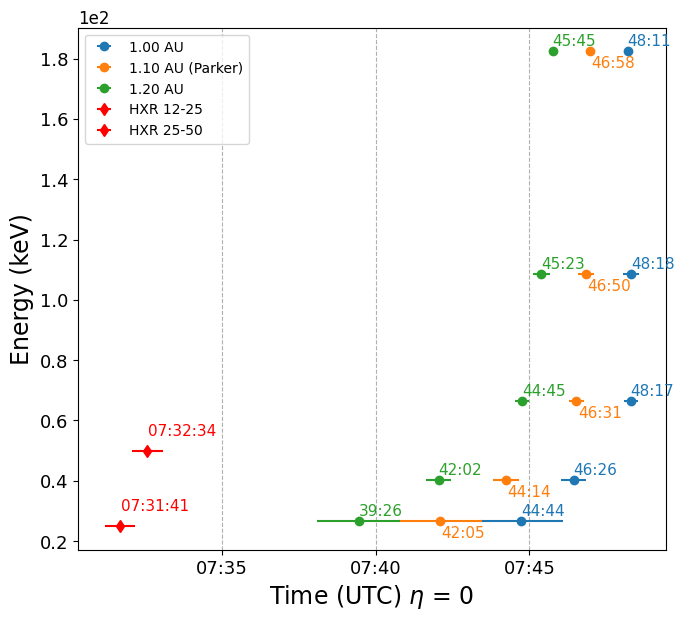

In [9]:
# Create a group of timing from other observations, e.g., HXR, type III bursts
hxrTime = [ # (time, y_value, label)
    ("2014-02-20 07:31:41", 25, "HXR 12-25"),
    ("2014-02-20 07:32:34", 50, "HXR 25-50")
    ] 
hxrGroup = timingGroup.EventTimingGroup(hxrTime, source="Fermi", isReleaseTime = True, radial_distance=1.0, color='r', marker='d')

pro.extraData = {'HXR': hxrGroup}

pro.fvda_approach2(plotExtraData= pro.extraData)

## Save the results to Excel and Pickle file
Automatically save to 'Event' file by default.

- FVDA analysis results will be saved in .xlsx file

- The processor object is stored in the pickle file. Can be easily retrieved without running the code again.

In [10]:
# Export to Excel
pro.exportResultToExcel(resultFilePath = None)

# Save the EventProcessor instance result to pickle
import pickle
pro.saveResultToPickle(resultFilePath = None)

## Load EventProcessor object from Pickle file
- (1) import the eventProcessor (import pyfvda.eventProcessor as processor)

- (2) processor.EventProcessor.load_fromPickle(file_path = '...')
    - Return the EventProcessor object


In [54]:
# pickle.load(open('eventProcessor.pkl', 'rb'))
import pyfvda.eventProcessor as processor
import pyfvda.eventTimingGroup as timingGroup
import numpy as np
import pandas as pd

pro_fromFile = processor.EventProcessor.load_fromPickle(file_path = './Event/WIND_2014-02-20 07_20_M3.0/WIND_2014-02-20 07_20_M3.0_EventProcessor.pkl')